# Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
plt.rcParams.update({'font.size': 12})

# Load & Annotate Data

In [2]:
dataframe_file = "./dataframes/dataframe_complete_20210420.csv.gz"

In [3]:
df = pd.read_csv(dataframe_file,sep = ";")#,na_filter=False) # <- problem with continent code NA for North America, if continent code is needed set na_filter=False

In [4]:
df["count"] = 1
df

,dns.id,udp.port,ts_request,ip_request,asn_request,country_request,ts_response,ip_response,asn_response,country_response,a_records,asn_arecord,ip.ttl,response_type,count
0,0x00000a2f,43515,1.619000e+09,131.108.157.147,61681.0,BRA,1.619000e+09,8.8.8.8,15169.0,USA,172.217.35.133,15169.0,121.0,Transparent Forwarder,1
1,0x00000f17,56744,1.619000e+09,190.111.158.51,270430.0,BRA,1.619000e+09,8.8.8.8,15169.0,USA,172.217.37.1,15169.0,121.0,Transparent Forwarder,1
2,0x000016f8,43480,1.619000e+09,200.115.110.81,270287.0,BRA,1.619000e+09,8.8.8.8,15169.0,USA,172.253.230.3,15169.0,121.0,Transparent Forwarder,1
3,0x00001adf,48128,1.619000e+09,45.4.178.144,266097.0,BRA,1.619000e+09,1.1.1.1,13335.0,USA,172.68.17.120,13335.0,57.0,Transparent Forwarder,1
4,0x00001b5b,38070,1.619000e+09,177.131.8.39,262375.0,BRA,1.619000e+09,1.1.1.1,13335.0,USA,172.68.17.120,13335.0,57.0,Transparent Forwarder,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127625,0x00001989,58439,1.619054e+09,200.98.169.165,7162.0,URY,1.619054e+09,200.98.169.165,7162.0,URY,200.98.169.165,7162.0,103.0,Resolver,1
2127626,0x000039db,50711,1.619054e+09,178.252.182.234,51074.0,RUS,1.619054e+09,178.252.182.234,51074.0,RUS,178.252.182.234,51074.0,111.0,Resolver,1
2127627,0x000068d4,48034,1.619054e+09,93.145.125.242,30722.0,ITA,1.619054e+09,93.145.125.242,30722.0,ITA,93.145.125.242,30722.0,51.0,Resolver,1
2127628,0x000082ce,48183,1.619054e+09,190.57.77.228,12127.0,SLV,1.619054e+09,190.57.77.228,12127.0,SLV,190.57.77.228,12127.0,118.0,Resolver,1


In [5]:
df_tf_asns = df[ (df["response_type"]=="Transparent Forwarder") &
    (pd.notnull(df["asn_request"]))].groupby(["country_request"])\
    ["asn_request"].nunique().to_dict()

df_tf_asns["BRA"]

1236

In [6]:
df_by_country_total = df.groupby(["country_request","response_type"]).sum().reset_index()[["country_request","response_type","count"]]

In [7]:
def get_freq(country,df,mode):
    if mode=="trans_rel":
        try:
            return (df[(df["country_request"]==country) & (df["response_type"]=="Transparent Forwarder")]["count"].tolist()[0] / df[(df["country_request"]==country)]["count"].sum())*100
        except:
            return 0
    elif mode=="trans_abs":
        try:
            return df[(df["country_request"]==country) & (df["response_type"]=="Transparent Forwarder")]["count"].tolist()[0]
        except:
            return 0
    elif mode=="fwd":
        try:
            return (df[(df["country_request"]==country) & (df["response_type"]=="Forwarder")]["count"].tolist()[0] / df[(df["country_request"]==country)]["count"].sum())*100
        except:
            return 0
    elif mode=="res":
        try:
            return (df[(df["country_request"]==country) & (df["response_type"]=="Resolver")]["count"].tolist()[0] / df[(df["country_request"]==country)]["count"].sum())*100
        except:
            return 0
    else:
        return 0

In [8]:
df_country_index = df_by_country_total.groupby("country_request").count()
df_country_index = df_country_index.reset_index()
df_country_index["% Transparent Forwarder"] = df_country_index["country_request"].apply(get_freq,args=(df_by_country_total,"trans_rel"))
df_country_index["% Recursive Forwarder"] = df_country_index["country_request"].apply(get_freq,args=(df_by_country_total,"fwd"))
df_country_index["% Recursive Resolver"] = df_country_index["country_request"].apply(get_freq,args=(df_by_country_total,"res"))
df_country_index["# Transparent Forwarder"] = df_country_index["country_request"].apply(get_freq,args=(df_by_country_total,"trans_abs"))
df_country_index = df_country_index.set_index("country_request")[["% Transparent Forwarder","% Recursive Resolver","% Recursive Forwarder","# Transparent Forwarder"]]

In [9]:
emerging_markets = ["ARG","BGD","BRA","CHN","COL","EGY",
                    "IND","IDN","IRN","MYS","MEX",
                    "NGA","PHL","POL","RUS","SAU","ZAF",
                    "KOR","THA","TUR"]

# ODNS Compenents per Country (HBAR)

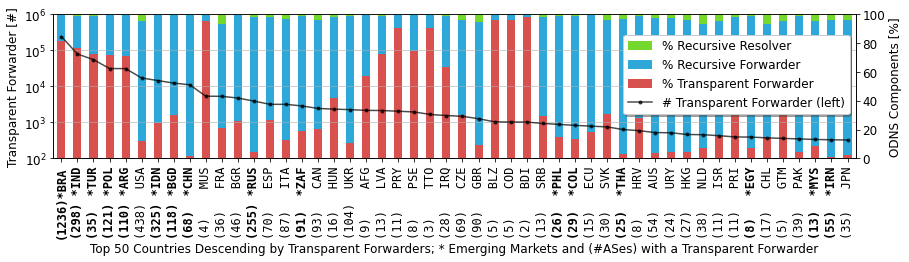

In [10]:
df_sorted = df_country_index.sort_values("# Transparent Forwarder",ascending=False).head(50)
df_sorted.index = df_sorted.index.map(lambda ccc:
                    f"({df_tf_asns[ccc]}){(4-len(str(df_tf_asns[ccc])))*' '}{'*' if ccc in emerging_markets else ' '}{ccc}")

# fill up spaces with-->  {(4-len(str(df_tf_asns[ccc])))*' '}

share_cols = ["% Transparent Forwarder", "% Recursive Forwarder","% Recursive Resolver",]

ax = df_sorted[share_cols].plot.bar(stacked=True, figsize=(14*0.9,4*0.9), #figsize=(8*0.9,3*0.9),
                                 color=["#D9514E", "#2DA8D8","#74d82d"])
# plot count as line
ax2 = df_sorted["# Transparent Forwarder"].plot(marker=".", c="black", ax=ax,
                               secondary_y=True, rot=90, alpha=0.7)
ax.set_ylabel("ODNS Components [%]")
ax.set_xlabel("Top 50 Countries, Descending by Total Transparent Forwarder Count")
ax.set_xlabel("Top 50 Countries Descending by Transparent Forwarders; * Emerging Markets and (#ASes) with a Transparent Forwarder")
ax.set_ylim((0,100))
ax2.set_ylabel("Transparent Forwarder [#]")
ax2.set_yscale("symlog")
ax2.set_ylim((10**2,10**6))
ax2.grid(alpha=0.7, zorder=-1000)
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend().remove()
# insert -1 for reverse sort orter
ax2.legend(handles[::-1] + handles2,
          labels[::-1] + [ l.split("(")[0]+"(left)" for l in labels2],
          loc="best", bbox_to_anchor=(0.5, 0.4, 0.5, 0.5),fancybox=True, shadow=True)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax2.yaxis.set_label_position("left")
ax2.yaxis.tick_left()

fontPropertiesMono = {
    'font' :  "Bitstream Vera Sans Mono", #"Andale Mono",
    'weight' : 'normal',
    'size' : 12}

ax.set_xticklabels(ax.get_xticklabels(),
                   **fontPropertiesMono)

for label in ax.get_xticklabels():
    if label.get_text()[-3:] in emerging_markets:
        label.set_fontweight("bold")

# save and clean up
fig = ax.get_figure()
fig.tight_layout(pad=0.5)
fig.savefig("./figures/bars_topxcc_odns_shares.pdf")
plt.show()
plt.close(fig)

# Transparent Forwarders per Country (CDF)

In [11]:
def get_trans_fwd_count(index, df):
    r_type = df[df.index==index]["response_type"].tolist()[0]
    if r_type == "Transparent Forwarder":
        return df[df.index==index]["count"].tolist()[0]
    else:
        return 0

172 221


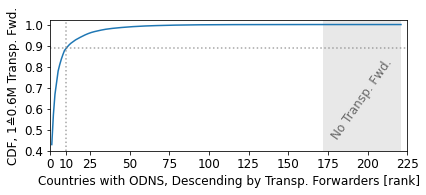

In [12]:
# calc reverse cdf
df_tmp = df_by_country_total.copy().reset_index()
df_tmp["transp fwd count"] = df_tmp["index"].apply(
    get_trans_fwd_count, args=(df_by_country_total,))
df_tmp = df_tmp.groupby("country_request").sum("transp fwd count").reset_index()
df_tmp = df_tmp.sort_values(by=["transp fwd count"],ascending=False)
sr_cdf = df_tmp["transp fwd count"].reset_index(drop=True)
sr_cdf.index += 1
sr_cdf = (sr_cdf.cumsum()/sr_cdf.sum())

# plot
ax = sr_cdf.plot(figsize=(8*0.8,3*0.8), logx=False)

# show country range without transparent forwarders
print(sr_cdf[sr_cdf==1].index.min(), sr_cdf[sr_cdf==1].index.max())

# add markers, hightlight stuff
ax.set_xticks(list(range(0,251,25)) + [10])
ax.set_yticks(list(np.arange(0.4,1.05,0.1)))
ax.axvline(10, linestyle=":", color="gray", alpha=0.7, linewidth=1.5)
ax.axhline(0.886180, linestyle=":", color="gray", alpha=0.7, linewidth=1.5)
plt.axvspan(172,221, facecolor='lightgrey', alpha=0.5)
ax.text(176, 0.46, "No Transp. Fwd.", size=12, color='dimgrey', rotation=55) # 176 for 0.9

# polish plot
ax.set_xlim(0,225)
ax.set_ylim(0.4,1.02)
ax.set_xlabel("Countries with ODNS, Descending by Transp. Forwarders [rank]")
ax.set_ylabel("CDF, 1≙0.6M Transp. Fwd.")

# save to file
fig = ax.get_figure()
fig.savefig("./figures/cdf_transp_fwd_per_cc.pdf", bbox_inches='tight')
plt.show()
plt.close(fig)

# Public Resolvers per Country (Heatmap)

In [13]:
def get_company(asn):
    if asn in [139190, 139070, 45566, 16591, 15169, 19527, 36040, 43515, 16550]:
        return "google"
    elif asn == 13335:
        return "cloudflare"
    elif asn == 19281:
        return "quad9"
    elif asn == 36692:
        return "opendns"
    else:
        return "other"

In [14]:
df_heatmap_raw = df.copy()

df_heatmap_raw["company"] = df_heatmap_raw["asn_response"].apply(get_company)

In [15]:
df_others = df_heatmap_raw[(df_heatmap_raw["country_request"].isin(["BRA","IND","TUR","ARG","POL","USA","IDN","BGD","CHN","MUS"])) \
               & (df_heatmap_raw["response_type"]=="Transparent Forwarder") \
               & (df_heatmap_raw["company"]=="other")].groupby(["country_request","asn_response"]).count().reset_index()[["country_request","asn_response","count"]]

In [16]:
def get_freq_others(index, df):
    asn = df[df.index==index]["asn_response"].tolist()[0]
    country = df[df.index==index]["country_request"].tolist()[0]
    return df[df.index==index]["count"].tolist()[0]/df[(df["country_request"]==country)]["count"].sum()

In [17]:
df_tmp = df_others.copy().reset_index()
df_tmp["relative frequency"] = df_tmp["index"].apply(get_freq_others,args=(df_others,))
df_tmp = df_tmp[["country_request","asn_response","count","relative frequency"]]

In [18]:
df_heatmap_raw = df_heatmap_raw.groupby(["country_request","response_type","company"]).count().reset_index()[["country_request","response_type","company","count"]]
df_heatmap_raw = df_heatmap_raw[df_heatmap_raw["response_type"]=="Transparent Forwarder"]

In [19]:
def get_rel_for_company(country,df,mode):
    if mode=="total":
        return df[(df["country_request"]==country)]["count"].sum()
    else:
        try:
            return (df[(df["country_request"]==country) & (df["company"]==mode)]["count"].sum() / df[(df["country_request"]==country)]["count"].sum())*100
        except:
            return 0

In [20]:
df_heatmap = df_heatmap_raw.copy()
df_heatmap["Google"] = df_heatmap["country_request"].apply(get_rel_for_company,args=(df_heatmap_raw,"google"))
df_heatmap["Cloudflare"] = df_heatmap["country_request"].apply(get_rel_for_company,args=(df_heatmap_raw,"cloudflare"))
df_heatmap["Quad9"] = df_heatmap["country_request"].apply(get_rel_for_company,args=(df_heatmap_raw,"quad9"))
df_heatmap["OpenDNS"] = df_heatmap["country_request"].apply(get_rel_for_company,args=(df_heatmap_raw,"opendns"))
df_heatmap["Other"] = df_heatmap["country_request"].apply(get_rel_for_company,args=(df_heatmap_raw,"other"))
df_heatmap["TOTAL"] = df_heatmap["country_request"].apply(get_rel_for_company,args=(df_heatmap_raw,"total"))
df_heatmap = df_heatmap.drop_duplicates("country_request")
df_heatmap = df_heatmap.set_index("country_request")[["Google","Cloudflare","Quad9","OpenDNS","Other","TOTAL"]]

In [21]:
df_heatmap.index = df_heatmap.index.map(lambda ccc:
                    f"({df_tf_asns[ccc]}){(4-len(str(df_tf_asns[ccc])))*' '}{'*' if ccc in emerging_markets else ' '}{ccc}")

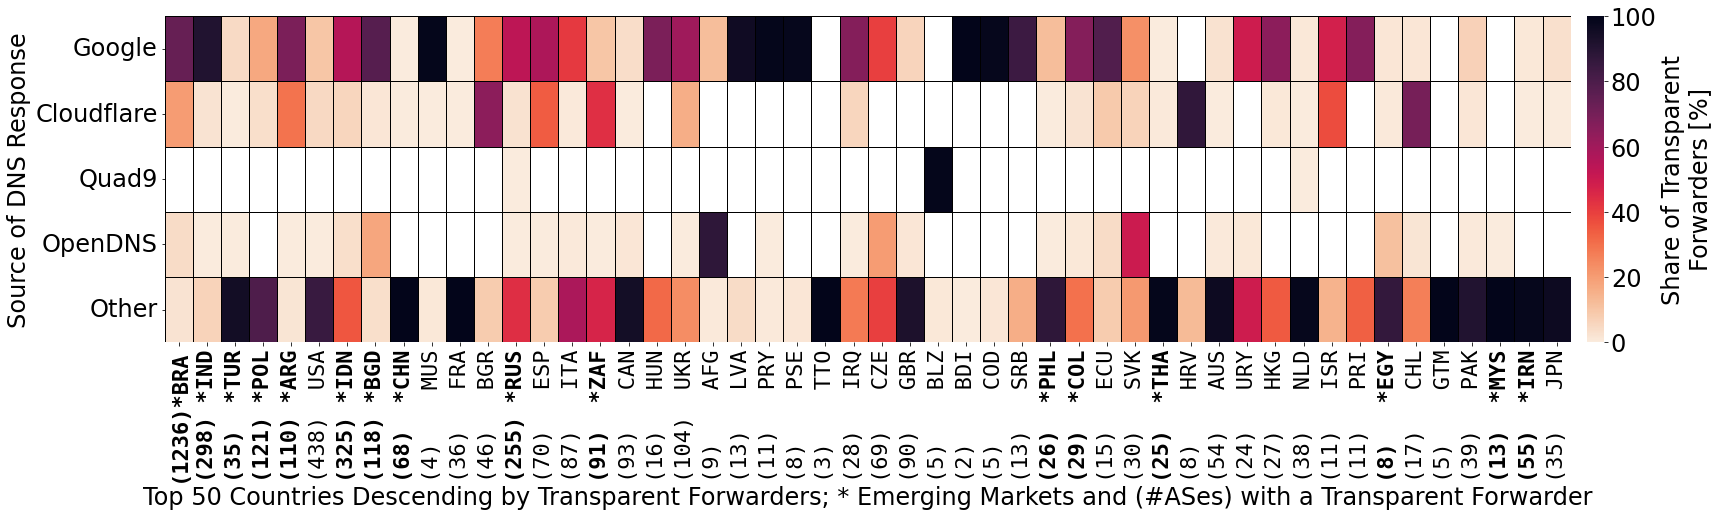

In [22]:
plt.rcParams.update({'font.size': 24})
plot_map = df_heatmap.sort_values("TOTAL",ascending=False)[["Google","Cloudflare","Quad9","OpenDNS","Other"]].head(50).transpose()

plt.figure(figsize=(30,6))
my_colormap = matplotlib.cm.get_cmap("rocket_r").copy()
my_colormap.set_under("w")
ax = sns.heatmap(plot_map, linewidth=1,linecolor="black",cmap=my_colormap,cbar_kws={"label":"Share of Transparent\nForwarders [%]","pad":0.01},\
                 square=False,vmin=0.01,vmax=100)

fontPropertiesSNS = {
    'font' :  "Bitstream Vera Sans Mono", #"Andale Mono",
    'weight' : 'normal',
    'size' : 22}

ax.set_xticklabels(ax.get_xticklabels(),
                   **fontPropertiesSNS)

for label in ax.xaxis.get_ticklabels():
    if label.get_text()[-3:] in emerging_markets:
        label.set_fontweight("bold")

cbar = ax.collections[0].colorbar
cbar.set_ticks([0.01, 20, 40, 60, 80, 100])
cbar.set_ticklabels(['0', '20', '40', '60','80', '100'])
plt.xlabel("Top 50 Countries, Descending by Total Transparent Forwarder Count")
plt.xlabel("Top 50 Countries Descending by Transparent Forwarders; * Emerging Markets and (#ASes) with a Transparent Forwarder")
plt.ylabel("Source of DNS Response")
plt.xticks(rotation=90)
fig = ax.get_figure()
fig.savefig("./figures/heatmap_dominance_pub_rr.pdf", bbox_inches='tight', pad_inches=0)
plt.rcParams.update({'font.size': 12})

# Transparent Forwarder Prefix Density

In [23]:
df_forwarders = df[ (df["response_type"]=="Transparent Forwarder") ].copy()
df_forwarders.head(3)

,dns.id,udp.port,ts_request,ip_request,asn_request,country_request,ts_response,ip_response,asn_response,country_response,a_records,asn_arecord,ip.ttl,response_type,count
0,0x00000a2f,43515,1.619000e+09,131.108.157.147,61681.0,BRA,1.619000e+09,8.8.8.8,15169.0,USA,172.217.35.133,15169.0,121.0,Transparent Forwarder,1
1,0x00000f17,56744,1.619000e+09,190.111.158.51,270430.0,BRA,1.619000e+09,8.8.8.8,15169.0,USA,172.217.37.1,15169.0,121.0,Transparent Forwarder,1
2,0x000016f8,43480,1.619000e+09,200.115.110.81,270287.0,BRA,1.619000e+09,8.8.8.8,15169.0,USA,172.253.230.3,15169.0,121.0,Transparent Forwarder,1


In [24]:
df_forwarders["prefix_request"] = df_forwarders["ip_request"].str.rstrip("".join(str(i) for i in range(10)))
df_forwarders.head()

,dns.id,udp.port,ts_request,ip_request,asn_request,country_request,ts_response,ip_response,asn_response,country_response,a_records,asn_arecord,ip.ttl,response_type,count,prefix_request
0,0x00000a2f,43515,1.619000e+09,131.108.157.147,61681.0,BRA,1.619000e+09,8.8.8.8,15169.0,USA,172.217.35.133,15169.0,121.0,Transparent Forwarder,1,131.108.157.
1,0x00000f17,56744,1.619000e+09,190.111.158.51,270430.0,BRA,1.619000e+09,8.8.8.8,15169.0,USA,172.217.37.1,15169.0,121.0,Transparent Forwarder,1,190.111.158.
2,0x000016f8,43480,1.619000e+09,200.115.110.81,270287.0,BRA,1.619000e+09,8.8.8.8,15169.0,USA,172.253.230.3,15169.0,121.0,Transparent Forwarder,1,200.115.110.
3,0x00001adf,48128,1.619000e+09,45.4.178.144,266097.0,BRA,1.619000e+09,1.1.1.1,13335.0,USA,172.68.17.120,13335.0,57.0,Transparent Forwarder,1,45.4.178.
4,0x00001b5b,38070,1.619000e+09,177.131.8.39,262375.0,BRA,1.619000e+09,1.1.1.1,13335.0,USA,172.68.17.120,13335.0,57.0,Transparent Forwarder,1,177.131.8.


In [25]:
df_forwarders["prefix_request"].value_counts()

138.122.13.    256
143.137.19.    256
101.255.71.    256
212.5.32.      256
45.191.215.    256
              ... 
82.69.191.       1
78.188.213.      1
94.30.118.       1
192.83.165.      1
69.9.205.        1
Name: prefix_request, Length: 41869, dtype: int64

In [26]:
num_middlebox_prefixes = len(df_forwarders["prefix_request"].value_counts()[lambda x: x>=254])
num_middlebox_prefixes

806

In [27]:
num_cpe = df_forwarders["prefix_request"].value_counts()[lambda x: x<=25].sum()
print(num_cpe, num_cpe/df_forwarders["ip_request"].nunique()*100)

144793 25.696118065883205


In [28]:
num_middle = df_forwarders["prefix_request"].value_counts()[lambda x: x>=254].sum()
print(num_middle, num_middle/df_forwarders["ip_request"].nunique()*100)

205634 36.49344610830514


0.25696118065883206


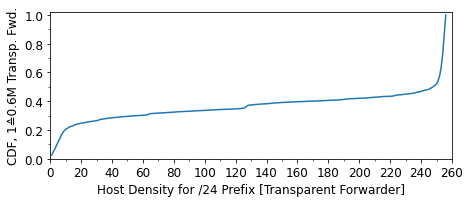

In [29]:
sr = df_forwarders["prefix_request"].value_counts().reset_index().groupby(
        ["prefix_request"])["prefix_request"].sum().cumsum()

sr /= sr.max()

ax = sr.plot(figsize=(8*0.9,3*0.9))

# polish plot
max_hosts = 256
ax.set_xticks(list(range(0,261,20))) # + [max_hosts])
ax.set_xlim(0,260)#max_hosts)
ax.set_ylim(0.,1.02)
ax.set_xlabel("Number of Transparent Forwarders in /24 Prefix [#]")
ax.set_xlabel("Host Density for /24 Prefix [Transparent Forwarder]")
ax.set_ylabel(f"CDF, 1≙{len(df_forwarders)//1000}k Transp. Fwds")
ax.set_ylabel(f"CDF, 1≙0.6M Transp. Fwd.")

# highlight value
xmark = 25 # 25
ymark = sr[sr.index==xmark].values[0]
print(ymark)
#ax.axvline(xmark, linestyle="dotted", color="grey", alpha=0.7, linewidth=1.5)
#ax.axhline(ymark, linestyle="dotted", color="grey", alpha=0.7, linewidth=1.5)
#ax.axvspan(254,256,facecolor='lightgrey', alpha=0.99)

# add minor ticks to improve readability
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# save to file
fig = ax.get_figure()
fig.savefig("./figures/cdf_transp_fwd_prefix_density.pdf", bbox_inches='tight')
plt.show()
plt.close(fig)

In [30]:
# save prefixes to cdf
df_forwarders["prefix_request"].value_counts()[lambda x: x>=254].reset_index()["index"].to_csv(
    "middlebox_prefixes_24.csv", sep=";", index=False, header=False)

df_forwarders["prefix_request"].value_counts()[lambda x: x<=25].reset_index()["index"].to_csv(
    "cpe_prefixes_24.csv", sep=";", index=False, header=False)

# DNSRoute++ Public Resolver Path Lengths (CDF)

In [31]:
df_dnsroute = pd.concat([
    pd.read_csv("./dataframes/dnsRoute_processed.csv.gz",sep=";"),
    pd.read_csv("./dataframes/dnsRoute_processed_2.csv.gz",sep=";"),
])

In [32]:
len(df_dnsroute)

74324

In [33]:
df_dnsroute.head()

,ip.target,asn.target,hops.to_target,ip.resolver,hops.from_target_to_resolver,hop.id.in,ip.in,asn.in,hop.id.out,ip.out,asn.out,missing_hops.to_target,missing_hops.from_target_to_resolver,has_dns_answer_before_reaching_target,path.from_target_to_resolver
0,179.108.27.175,263267.0,15,8.8.8.8,7,14,192.140.116.202,266240.0,-1,NaN,NaN,2,1,0,"[(17, '192.140.116.201'), (18, '191.242.223.23..."
1,45.228.249.238,267126.0,13,8.8.8.8,10,-1,NaN,NaN,14,177.107.144.253,28250.0,6,5,0,"[(14, '177.107.144.253'), (20, '74.125.51.210'..."
2,185.136.242.225,203374.0,16,185.136.242.164,3,-1,NaN,NaN,-1,NaN,NaN,8,2,0,[]
3,177.11.191.176,52904.0,10,8.8.8.8,9,9,131.221.20.34,264415.0,12,131.221.20.181,264415.0,0,3,0,"[(11, '177.11.189.53'), (12, '131.221.20.181')..."
4,170.233.94.69,264736.0,9,1.0.0.1,7,8,190.228.124.254,7303.0,10,190.228.124.254,7303.0,0,3,0,"[(10, '190.228.124.254'), (11, '190.224.11.25'..."


In [34]:
# maps resolver projects
r_names = {
    "1.1.1.1":"Cloudflare",
    "1.1.1.2":"Cloudflare",
    "1.1.1.3":"Cloudflare",
    "1.0.0.1":"Cloudflare",
    "1.0.0.2":"Cloudflare",
    "1.0.0.3":"Cloudflare",
    "8.8.8.8":"Google",
    "8.8.4.4":"Google",
    "208.67.222.222":"OpenDNS",
    "208.67.220.220":"OpenDNS",
    "208.67.222.123":"OpenDNS",
    "208.67.220.123":"OpenDNS",
    "208.67.222.2":"OpenDNS",
    "208.67.220.2":"OpenDNS",}

df_dnsroute["ip.resolver.name"] = df_dnsroute["ip.resolver"].map(r_names)


===Google===
count    57725.000000
mean         7.916293
std          2.623934
min          1.000000
25%          6.000000
50%          7.000000
75%          9.000000
max         22.000000
Name: hops.from_target_to_resolver, dtype: float64

===Cloudflare===
count    8271.000000
mean        6.330190
std         2.290226
min         2.000000
25%         4.000000
50%         7.000000
75%         8.000000
max        22.000000
Name: hops.from_target_to_resolver, dtype: float64

===OpenDNS===
count    3963.000000
mean        9.364875
std         2.681964
min         3.000000
25%         7.000000
50%         9.000000
75%        11.000000
max        19.000000
Name: hops.from_target_to_resolver, dtype: float64


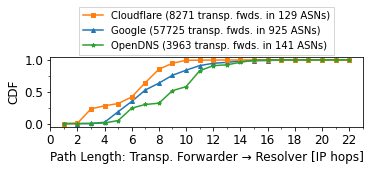

In [35]:
# lets only inspect the well-known, present resolvers
plt.rcParams.update({'font.size': 12})
top_resolver = ["Google","Cloudflare","OpenDNS"]

grp_top = df_dnsroute.groupby(["ip.resolver.name"])

cdfs = []
for resolver in top_resolver:
    
    # grep data for plot
    subdf = grp_top.get_group(resolver)
    tmp = subdf["hops.from_target_to_resolver"].value_counts(
            normalize=True).sort_index().cumsum()
    tmp = tmp.rename(f"{resolver} ({subdf['ip.target'].nunique()} transp. fwds. in {subdf['asn.target'].nunique()} ASNs)")
    cdfs.append(tmp)
    
    print(f"\n==={ resolver }===")
    print(subdf["hops.from_target_to_resolver"].describe())

# create CDF dataframe
df_cdfs = pd.concat(cdfs, axis=1).ffill().fillna(0)    

# and finally plot it

ax = df_cdfs.plot(figsize=(8*0.7,3*0.43), style=["-^","-s","-*"], markersize=4)

ax.set_xlabel("Path Length: Transp. Forwarder → Resolver [IP hops]")
ax.set_ylabel("CDF")
ax.set_xticks(list(range(0,24,2)))
# ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_yticks([0,0.5, 1])
ax.set_xlim((0,23))

# add minor ticks to improve readability
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# fix order in legend and improve pos
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[1], handles[0], handles[2]], [labels[1], labels[0], labels[2]],
          loc='upper center', bbox_to_anchor=(0.5, 1.78),
          ncol=1, fancybox=False, shadow=False, prop={"size":10})

fig = ax.get_figure()
fig.savefig("./figures/cdf_hop_distance_resolvers.pdf", bbox_inches='tight')
plt.show()
plt.close(fig)